# [AIM 2022](https://data.vision.ee.ethz.ch/cvl/aim22/) - Reverse ISP Challenge

### [Track 1 - S7](https://codalab.lisn.upsaclay.fr/competitions/5079)
### [Track 2 - HP20](https://codalab.lisn.upsaclay.fr/competitions/5080)


<img src=https://i.ibb.co/wgRBGQq/aim-challenge-teaser.jpg>


Digital cameras transform sensor RAW readings into RGB images by means of their Image Signal Processor (ISP). Computational photography tasks such as image denoising and colour constancy are commonly performed in the RAW domain, in part due to the inherent hardware design, but also due to the appealing simplicity of noise statistics that result from the direct sensor readings. Despite this, the availability of RAW images is limited in comparison with the abundance and diversity of available RGB data. Recent approaches have attempted to bridge this gap by estimating the RGB to RAW mapping.

In this challenge, we look for solutions to recover RAW readings from the camera using only the corresponding RGB images processed by the in-camera ISP. Successful solutions should generate plausible RAW images, and by doing this, other downstream tasks like Denoising, Super-resolution or Colour Constancy can benefit from such synthetic data generation.

## Datasets

**Samsung S7**

We use a custom version of the dataset collected by Schwartz et al. in their work *[DeepISP: Learning End-to-End Image Processing Pipeline](https://arxiv.org/abs/1801.06724)*. We process the original RAW images (GRBG pattern) and extract "aligned" RGB-RAW crop pairs.

**EH Huawei P20 Dataset**

We use a custom version of the dataset from [ETH PyNET by Ignatov et al.](http://people.ee.ethz.ch/~ihnatova/pynet.html#dataset), a large-scale dataset consisting of RAW-RGB image pairs captured in the wild with the Huawei P20 camera (12.3 MP Sony Exmor IMX380 sensor).
More information in their paper *[Replacing Mobile Camera ISP with a Single Deep Learning Model](https://arxiv.org/abs/2002.05509)*


In both tracks, we provide RAW and RGB images extracted from the camera ISP. 
- RAW images are provided in `.npy` format, as 4-channel images following the RGGB pattern
- RGB images are provided in `.jpg` format

You can download the competition data after registering at the challenge [here](https://codalab.lisn.upsaclay.fr/competitions/5079).

- Track 1 data is approx 3 Gb
- Track 2 data is approx 2.5 Gb

## Hints and Tips

- RAW images are provided as `np.uint16` with max value `2**10 = 1024`. 
- The RAW images are packed as (h,w,4) , you can unpack it and obtain a (h*2, w*2,1) RAW using the corresponding utils. We recommend to use the 4-channel RAW image.
- RAW images are already converted to standard RGGB pattern.
- Mosaic and Demosaic are provided for visualization purposes only.
- For the S7 dataset, most of the images are well-aligned, SSIM and PSNR should work as perceptual metrics.
- For the HP20 dataset, most of the images are **not** aligned. The RGB from the ISP is the process of many transformations includding cropping and zooming. Therefore we recomend perceptual losses as SSIM, MSSSIM and KL-Divergence. In this track, we focus on SSIM as standard metric, but we will consider internally the other mentioned metrics. 
- The ISP corrects many artifacts such as noise and blur. The original RAW images threfore might contain such artifacts.

In [1]:
!pip -q install gdown
!pip -q install rawpy

At the challenge website you can register and access to the data: https://codalab.lisn.upsaclay.fr/competitions/5079

The data sctructure should be as follows:

```
├── data-p20
│   ├── train
│   └── val_rgb
└── data-s7
    ├── train
    └── val_rgb
    
```

`data-p20` should be around 3 Gb and `data-s7` should be around 2.5 Gb

- `train/` contains RGBs in `.jpg` format and RAWs in `.npy` format
- `val_rgb/` contains RGBs in `.jpg`

From the corresponding RGBs, you need to reverse the ISP operations an provide the corresponding RAW image.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import rawpy
import sys
import os
import gc
import random
from glob import glob
from tqdm import tqdm
from skimage.metrics import mean_squared_error as MSE

### Utils

In [26]:
def extract_bayer_channels(raw):

    ch_B  = raw[1::2, 1::2]
    ch_Gb = raw[0::2, 1::2]
    ch_R  = raw[0::2, 0::2]
    ch_Gr = raw[1::2, 0::2]

    return ch_R, ch_Gr, ch_B, ch_Gb

def load_rawpy (raw_file):
    raw = rawpy.imread(raw_file)
    raw_image = raw.raw_image
    return raw_image

def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
        
    return img

def save_rgb (img, filename):
    if np.max(img) <= 1:
        img = img * 255
    
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    cv2.imwrite(filename, img)
    
def load_raw_png(raw, debug=False):
    '''
    Load RAW images from the ZurichRAW2RGB Dataset
    Reference: https://github.com/aiff22/PyNET-PyTorch/blob/master/dng_to_png.py
    by Andrey Ignatov.
    
    inputs:
     - raw: filename to the raw image saved as '.png'
    returns:
     - RAW_norm: normalized float32 4-channel raw image with bayer pattern RGGB.
    '''
    
    assert '.png' in raw
    raw = np.asarray(imageio.imread((raw)))
    ch_R, ch_Gr, ch_B, ch_Gb = extract_bayer_channels (raw)

    RAW_combined = np.dstack((ch_R, ch_Gr, ch_Gb, ch_B))
    RAW_norm = RAW_combined.astype(np.float32) / (4 * 255)
    RAW_norm = np.clip(RAW_norm, 0, 1)
    
    if debug:
        print (RAW_norm.shape, RAW_norm.dtype, RAW_norm.min(), RAW_norm.max())

    # raw as (h,w,1) in RGBG domain! do not use
    raw_unpack = raw.astype(np.float32) / (4 * 255)
    raw_unpack = np.expand_dims(raw_unpack, axis=-1)
    
    return RAW_norm

def load_raw(raw, max=2**10):
    raw = np.load (raw)/ max
    return raw.astype(np.float32)


########## RAW image manipulation

def unpack_raw(im):
    """
    Unpack RAW image from (h,w,4) to (h*2 , w*2, 1)
    """
    h,w,chan = im.shape 
    H, W = h*2, w*2
    img2 = np.zeros((H,W))
    img2[0:H:2,0:W:2]=im[:,:,0]
    img2[0:H:2,1:W:2]=im[:,:,1]
    img2[1:H:2,0:W:2]=im[:,:,2]
    img2[1:H:2,1:W:2]=im[:,:,3]
    img2 = np.squeeze(img2)
    img2 = np.expand_dims(img2, axis=-1)
    return img2

def pack_raw(im):
    """
    Pack RAW image from (h,w,1) to (h/2 , w/2, 4)
    """
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]
    ## R G G B
    out = np.concatenate((im[0:H:2,0:W:2,:], 
                       im[0:H:2,1:W:2,:],
                       im[1:H:2,0:W:2,:],
                       im[1:H:2,1:W:2,:]), axis=2)
    return out



########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image


def mosaic(rgb):
    """Extracts RGGB Bayer planes from an RGB image."""
    
    assert rgb.shape[-1] == 3
    shape = rgb.shape
    
    red        = rgb[0::2, 0::2, 0]
    green_red  = rgb[0::2, 1::2, 1]
    green_blue = rgb[1::2, 0::2, 1]
    blue       = rgb[1::2, 1::2, 2]
    
    image = np.stack((red, green_red, green_blue, blue), axis=-1)
    return image


def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def plot_pair (rgb, raw, t1='RGB', t2='RAW', axis='off'):
    
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.subplot(1,2,1)
    plt.title(t1)
    plt.axis(axis)
    plt.imshow(rgb)

    plt.subplot(1,2,2)
    plt.title(t2)
    plt.axis(axis)
    plt.imshow(raw)
    plt.show()

########## METRICS

def PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [27]:
def get_filenames(path):
    train_raws = sorted(glob(PATH + '/train/*.npy'))
    train_rgbs = sorted(glob(PATH + '/train/*.jpg'))
    valid_rgbs = sorted(glob(PATH + '/val_rgb/*'))
    assert len(train_raws) == len(train_rgbs)
    print (f'Training samples: {len(train_raws)} \t Validation samples: {len(valid_rgbs)}')
    return train_raws, train_rgbs, valid_rgbs

### Check RGB-RAW Training pairs - Huawei P20

In [82]:
DATASET = 'p20' # 's7'
PATH    = f'data-{DATASET}'

In [83]:
train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)

Training samples: 5760 	 Validation samples: 720


data-p20/train/126_34.jpg data-p20/train/126_34.npy


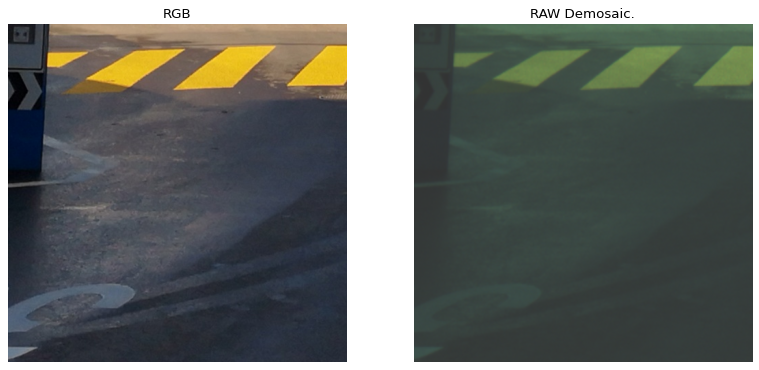

In [58]:
rgb_file, raw_file = random.choice(list(zip(train_rgbs, train_raws)))
print (rgb_file, raw_file)

rgb    = load_img (rgb_file, norm=True)
raw    = load_raw (raw_file, max= 4*255)
raw_dm = postprocess_raw(demosaic(raw))
rgb2raw= mosaic(rgb)

plot_pair(rgb, raw_dm, t1=f'RGB', t2='RAW Demosaic.')

### Check Validation RGB - Huawei P20

data-p20/val_rgb/147_42.jpg


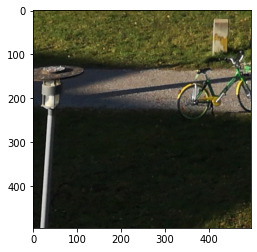

In [59]:
rgb_file = random.choice(valid_rgbs)
print (rgb_file)
rgb = load_img (rgb_file, norm=True)
plt.imshow(rgb)
plt.show()    

### Check RGB-RAW Training pairs - Samsung S7

In [84]:
DATASET = 's7' # 's7'
PATH    = f'data-{DATASET}'

In [85]:
train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)

Training samples: 4320 	 Validation samples: 480


data-s7/train/65_18.jpg data-s7/train/65_18.npy


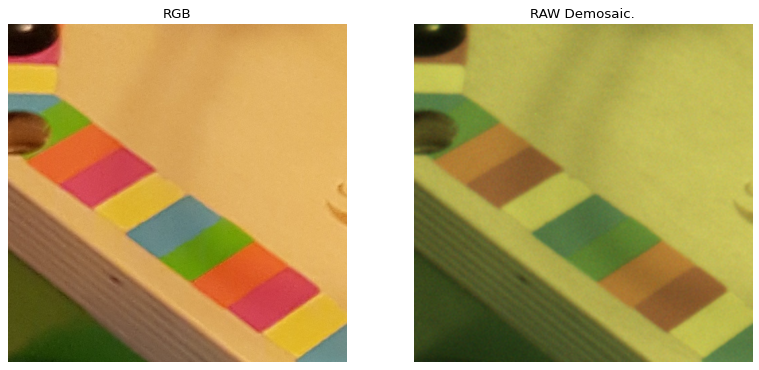

In [64]:
rgb_file, raw_file = random.choice(list(zip(train_rgbs, train_raws)))
print (rgb_file, raw_file)

rgb    = load_img (rgb_file, norm=True)
raw    = load_raw (raw_file, max=2**10)
raw_dm = postprocess_raw(demosaic(raw))
rgb2raw= mosaic(rgb)

plot_pair(rgb, raw_dm, t1=f'RGB', t2='RAW Demosaic.')

### Check Validation RGB - Samsung S7

data-s7/val_rgb/23_43.jpg


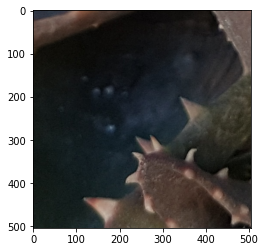

In [70]:
rgb_file = random.choice(valid_rgbs)
print (rgb_file)
rgb = load_img (rgb_file, norm=True)
plt.imshow(rgb)
plt.show()    